In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})
import time

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")

fileinprefix = "SnapshotAr41*.csv"
df_ar41 = load_dataframe_from_files(dirin, fileinprefix)
df_ar41 = df_ar41[df_ar41.columns[:-1]]

print("[Info] Loaded data in {:.3f} seconds".format(time.time() - init))

[Info] Loading 1 files wt prefix:
SnapshotAr41*.csv

[Info] Loaded data in 0.034 seconds


In [4]:
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileinprefix = "Snapshot1Ar39*.csv"
df_ar39 = load_dataframe_from_files(dirin, fileinprefix)
df_ar39 = df_ar39[df_ar39.columns[:-1]]

print("[Info] Loaded data in {:.3f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*.csv
...................................................................................................
[Info] Loaded data in 59.476 seconds


# select data

In [5]:
min_pe, max_pe = 5, 50
cutar39 = df_ar39[(df_ar39.pedetected>=min_pe) & (df_ar39.pedetected<=max_pe)]
cutar41 = df_ar41[(df_ar41.pedetected>=min_pe) & (df_ar41.pedetected<=max_pe)]
print("[Info] Ar39: original events: {}, selected events: {}".format(len(df_ar39), len(cutar39)))
print("[Info] Ar41: original events: {}, selected events: {}".format(len(df_ar41), len(cutar41)))

[Info] Ar39: original events: 5303515, selected events: 461921
[Info] Ar41: original events: 11733, selected events: 7203


In [6]:
# remove test data from ar41
n_test_ar41 = round(.10 * len(cutar41))
id_ar41 = np.arange(len(cutar41))
np.random.shuffle(id_ar41)
test_ar41, train_ar41 = cutar41.iloc[id_ar41[:n_test_ar41], :], cutar41.iloc[id_ar41[n_test_ar41:], :]

# augment ar41 data by rolling

In [7]:
import warnings
def augment_muons_by_roll(muon_df, n_inner_slices=12, n_outer_slices=20, n_inner_roll=3, n_outer_roll=5):
    X_inner = muon_df.iloc[:, :n_inner_slices].to_numpy()
    X_outer = muon_df.iloc[:, n_inner_slices:n_inner_slices+n_outer_slices].to_numpy()
    if not n_inner_slices/n_inner_roll == n_outer_slices/n_outer_roll:
        warnings("[Warning] The inner/outer rolls are not consistent. Break.")
        return
    n_rolls = int(n_inner_slices / n_inner_roll)
    for roll in np.array(np.linspace(0, n_inner_slices, n_rolls+1)[:-1], dtype='int'):
        if roll==0:
            XX_inner = X_inner
        else:
            XX_inner = np.concatenate([XX_inner, np.roll(X_inner, roll, axis=1)])
    for roll in np.array(np.linspace(0, n_outer_slices, n_rolls+1)[:-1], dtype='int'):
        if roll==0:
            XX_outer = X_outer
        else:
            XX_outer = np.concatenate([XX_outer, np.roll(X_outer, roll, axis=1)])
    return pd.DataFrame(np.concatenate([XX_inner, XX_outer], axis=1))

In [11]:
#aug_ar41_train = augment_muons_by_roll(train_ar41.iloc[:, 3:])
aug_ar41_train = pd.DataFrame(train_ar41.iloc[:, 3:].to_numpy())
print("[Info] Augmented Ar41 Data: {} instances".format(len(aug_ar41_train)))

[Info] Augmented Ar41 Data: 6483 instances


# undersample ar39

In [12]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, ar39_df.pedetected.max()+1, ar39_df.pedetected.max()+2)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(0, ar39_df.pedetected.max()+1)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), number_of_instances), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, ar39_df.pedetected.max()+1):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

2.269014835357666


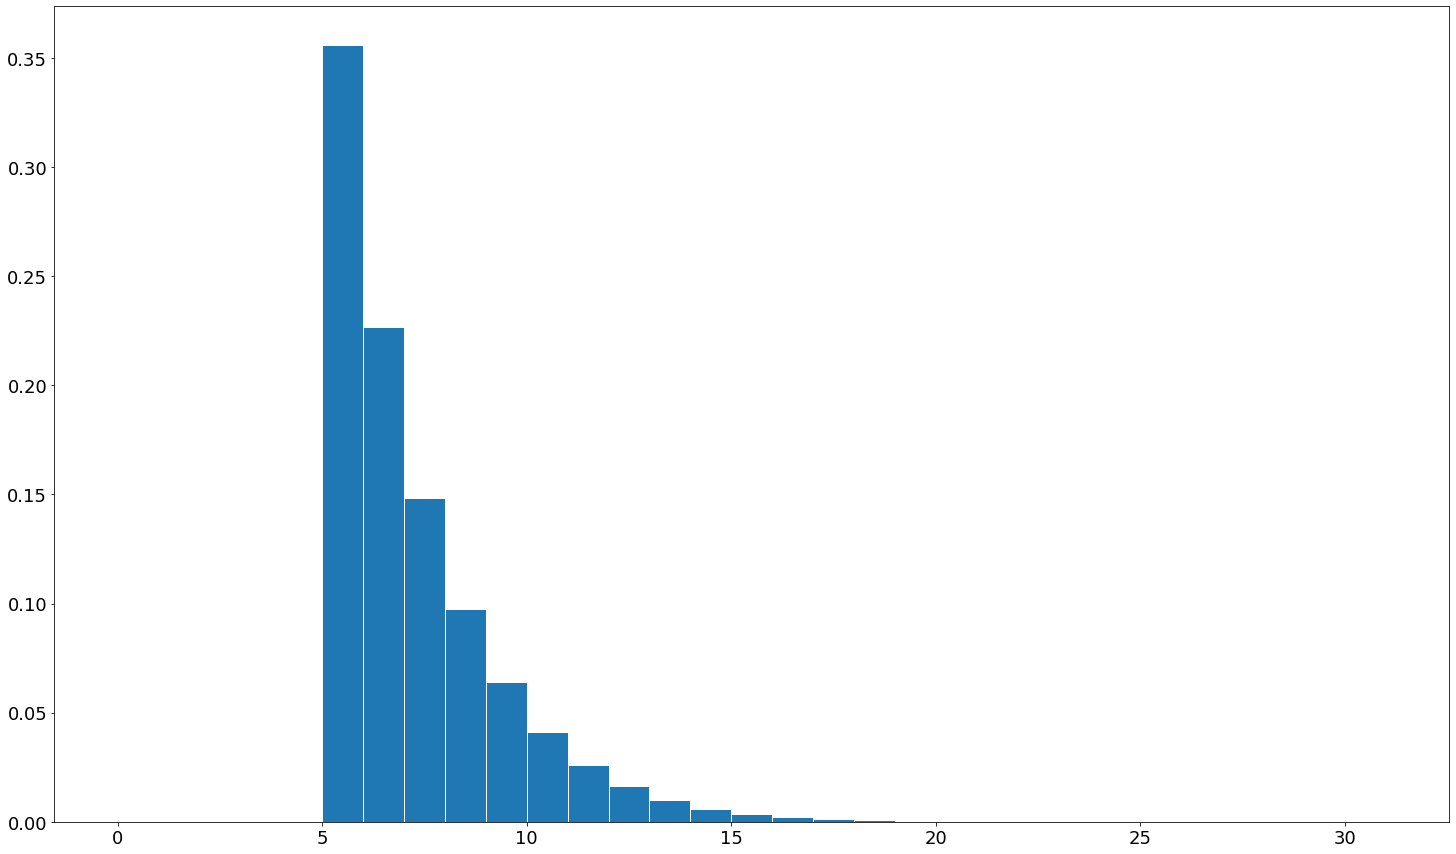

In [13]:
init = time.time()
skip_first_cols, n_inner_slices, n_outer_slices = 3, 12, 20

train_ar39 = undersample_argon(cutar39, round(len(aug_ar41_train))*1.5, augment_from_pe=15, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
print(time.time() - init)

In [14]:
print("[Info] Training set: {} instances".format(len(aug_ar41_train) + len(train_ar39)))
print("\tAr41: {} instances ({:.2f}%)".format(len(aug_ar41_train), len(aug_ar41_train) / (len(aug_ar41_train)+len(train_ar39))))
print("\tAr39: {} instances ({:.2f}%)".format(len(train_ar39), len(train_ar39) / (len(aug_ar41_train)+len(train_ar39))))

[Info] Training set: 16268 instances
	Ar41: 6483 instances (0.40%)
	Ar39: 9785 instances (0.60%)


In [15]:
aug_ar41_train["y"] = 1
train_ar39["y"] = 0
all_train = pd.concat([aug_ar41_train, train_ar39])
X, y = all_train.iloc[:, :-1], all_train.iloc[:, -1]
X = X.to_numpy().reshape((X.shape[0], X.shape[1], 1))    # to consistency with NN input
print("[Safety Check] Training data: {} instances".format(X.shape[0]))

[Safety Check] Training data: 16268 instances


# training

In [16]:
import tensorflow as tf
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False    # no deprecation warning print

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score

tf.test.is_gpu_available()

True

In [17]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential

In [18]:
def create_model(n_1_conv_layers=1, n_1_max_pooling_layers=1,
                 n_2_conv_layers=1, n_2_max_pooling_layers=1, n_3_dense_layers=1,
                 n_filters_1_conv_layers=64, kernel_size_1_conv_layers=6, activation_1_conv_layers='relu',
                 pool_size_1_max_pooling_layers=3,
                 n_filters_2_conv_layers=64, kernel_size_2_conv_layers=6, activation_2_conv_layers='relu',
                 pool_size_2_max_pooling_layers=3,
                 n_neurons_3_dense_layers=32, activation_3_dense_layers='relu',
                 activation_f_layer='sigmoid',
                 learningrate=0.01, decay=0.0, l1=0.01, l2=0.01, dropout=0.0,
                 input_shape=(32, 1), output_shape=1):
    print(".", end="")
    opt = tf.keras.optimizers.Adam(lr=learningrate, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = tf.keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()
    
    first=True    # for the firt layer we need to specify the input dimensions
    for i in range(n_1_conv_layers):
        if first:
            model.add(Conv1D(filters=n_filters_1_conv_layers, kernel_size=kernel_size_1_conv_layers, 
                             activation=activation_1_conv_layers, input_shape=input_shape))
            first=False
        else: 
            model.add(Conv1D(filters=n_filters_1_conv_layers, kernel_size=kernel_size_1_conv_layers, 
                             activation=activation_1_conv_layers))
        if dropout>0:
            model.add(Dropout(dropout))
         
    for i in range(n_1_max_pooling_layers):
        model.add(MaxPooling1D(pool_size=pool_size_1_max_pooling_layers))
        if dropout>0:
            model.add(Dropout(dropout))
    
    for i in range(n_2_conv_layers):
        model.add(Conv1D(filters=n_filters_2_conv_layers, kernel_size=kernel_size_2_conv_layers, 
                         activation=activation_2_conv_layers))
        if dropout>0:
            model.add(Dropout(dropout))
          
    for i in range(n_2_max_pooling_layers):
        model.add(MaxPooling1D(pool_size=pool_size_2_max_pooling_layers))
        if dropout>0:
            model.add(Dropout(dropout))
    
    model.add(Flatten())
    
    previous_n_neurons = 2*n_neurons_3_dense_layers
    for i in range(n_3_dense_layers):        
        current_n_neurons = round(previous_n_neurons/2)
        model.add(Dense(current_n_neurons, activation=activation_3_dense_layers, kernel_regularizer=reg))
        previous_n_neurons = current_n_neurons
        if dropout>0:
            model.add(Dropout(dropout))
            
    model.add(Dense(output_shape, activation=activation_f_layer))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])
    return model

In [19]:
# define general architectur - # layers
n_1_conv_layers=2              # 1. series of conv layers. here define the nr of conv layers
n_1_max_pooling_layers=1       # 2. series of max pooling layers
n_2_conv_layers=1              # 3. series of conv layers
n_2_max_pooling_layers=1       # 4. series of max pooling layers
n_3_dense_layers=2             # 5. flatten -> series of dense layers

# define layers' details
n_filters_1_conv_layers, kernel_size_1_conv_layers = 64, 6
n_filters_2_conv_layers, kernel_size_2_conv_layers = 64, 3
n_neurons_3_dense_layers = 32
pool_size_1_max_pooling_layers=3
pool_size_2_max_pooling_layers=3

# define activation functions
activation_1_conv_layers = activation_2_conv_layers = activation_3_dense_layers = 'relu'
activation_f_layer='sigmoid'
                 
# optimizer
lr, decay = .01, .0
# regularization
dropout = 0.0
l1, l2 = .01, .02

m=create_model(n_1_conv_layers=n_1_conv_layers, n_1_max_pooling_layers=n_1_max_pooling_layers,
             n_2_conv_layers=n_2_conv_layers, n_2_max_pooling_layers=n_2_max_pooling_layers, n_3_dense_layers=n_3_dense_layers,
             n_filters_1_conv_layers=n_filters_1_conv_layers, kernel_size_1_conv_layers=kernel_size_1_conv_layers, 
             activation_1_conv_layers=activation_1_conv_layers,
             pool_size_1_max_pooling_layers=pool_size_1_max_pooling_layers,
             n_filters_2_conv_layers=n_filters_2_conv_layers, kernel_size_2_conv_layers=kernel_size_2_conv_layers, 
             activation_2_conv_layers=activation_2_conv_layers,
             pool_size_2_max_pooling_layers=pool_size_2_max_pooling_layers,
             n_neurons_3_dense_layers=n_neurons_3_dense_layers, activation_3_dense_layers=activation_3_dense_layers,
             activation_f_layer=activation_f_layer,
             learningrate=lr, decay=decay, l1=l1, l2=l2, dropout=dropout,
             input_shape=(32, 1), output_shape=1)

.

In [20]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 27, 64)            448       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 64)             12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [21]:
results = m.fit(X, y, epochs=10, shuffle=True)

Epoch 1/10
509/509 [==============================] - 3s 5ms/step - loss: 0.5806 - auc: 0.8765 - precision: 0.8436
Epoch 2/10
509/509 [==============================] - 3s 5ms/step - loss: 0.4173 - auc: 0.9084 - precision: 0.8127
Epoch 3/10
509/509 [==============================] - 3s 5ms/step - loss: 0.3988 - auc: 0.9163 - precision: 0.8107
Epoch 4/10
509/509 [==============================] - 3s 5ms/step - loss: 0.3962 - auc: 0.9167 - precision: 0.8164
Epoch 5/10
509/509 [==============================] - 3s 5ms/step - loss: 0.3897 - auc: 0.9195 - precision: 0.8139
Epoch 6/10
509/509 [==============================] - 3s 5ms/step - loss: 0.3883 - auc: 0.9213 - precision: 0.8163
Epoch 7/10
509/509 [==============================] - 3s 5ms/step - loss: 0.3828 - auc: 0.9235 - precision: 0.8217
Epoch 8/10
509/509 [==============================] - 3s 5ms/step - loss: 0.3775 - auc: 0.9234 - precision: 0.8195
Epoch 9/10
509/509 [==============================] - 3s 5ms/step - loss: 0.3766

# hyperparams tuning

In [37]:
# numbers of layers
n_1_conv_layers = [1, 2]    # 1. series of conv layers. here define the nr of conv layers
n_1_max_pooling_layers = [1]     # 2. series of max pooling layers
n_2_conv_layers = [1]       # 3. series of conv layers
n_2_max_pooling_layers = [1]     # 4. series of max pooling layers
n_3_dense_layers = [1, 2]    

# layers' details 
n_filters_1_conv_layers = [64]
n_filters_2_conv_layers = [32]
kernel_size_1_conv_layers = [4, 5, 6, 7, 8]
kernel_size_2_conv_layers = [2, 3, 4]
pool_size_1_max_pooling_layers = [2, 3]
pool_size_2_max_pooling_layers = [2, 3]
n_neurons_3_dense_layers = [16, 32, 64]

# activation
activation_1_conv_layers = ['relu']
activation_2_conv_layers = ['relu']
activation_3_dense_layers = ['relu']
activation_f_layer = ['sigmoid']

# learning algorithm parameters
lr = [1e-1]
decay = [1e-6]

# dropout and regularisation
dropout = [0]
l1 = [0.0001]
l2 = [0.0001]

# dictionary summary
param_grid = dict(n_1_conv_layers=n_1_conv_layers, n_1_max_pooling_layers=n_1_max_pooling_layers,
                  n_2_conv_layers=n_2_conv_layers, n_2_max_pooling_layers=n_2_max_pooling_layers, n_3_dense_layers=n_3_dense_layers,
                  n_filters_1_conv_layers=n_filters_1_conv_layers, kernel_size_1_conv_layers=kernel_size_1_conv_layers, 
                  activation_1_conv_layers=activation_1_conv_layers,
                  pool_size_1_max_pooling_layers=pool_size_1_max_pooling_layers,
                  n_filters_2_conv_layers=n_filters_2_conv_layers, kernel_size_2_conv_layers=kernel_size_2_conv_layers, 
                  activation_2_conv_layers=activation_2_conv_layers,
                  pool_size_2_max_pooling_layers=pool_size_2_max_pooling_layers,
                  n_neurons_3_dense_layers=n_neurons_3_dense_layers, activation_3_dense_layers=activation_3_dense_layers,
                  activation_f_layer=activation_f_layer,
                  learningrate=lr, decay=decay, l1=l1, l2=l2, dropout=dropout)

In [38]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# model class to use in the scikit random search CV 
n_epochs, batch_size = 3, 64
model = KerasClassifier(build_fn=create_model, epochs=n_epochs, batch_size=batch_size, verbose=0)

In [39]:
n_random_iterations=100
grid = RandomizedSearchCV(estimator=model, cv=KFold(3, shuffle=True), param_distributions=param_grid, scoring="roc_auc",
                          verbose=1,  n_iter=n_random_iterations, n_jobs=1)

In [40]:
print("[Info] Random Search CV")
print("\tNr Epochs: {}, Nr Random Iterations: {}".format(n_epochs, n_random_iterations))
init = time.time()
grid_result = grid.fit(X, y)
print("End in {:.3f} sec".format(time.time() - init))

[Info] Random Search CV
	Nr Epochs: 3, Nr Random Iterations: 100
Fitting 3 folds for each of 100 candidates, totalling 300 fits
.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


...........................................................................................................................................................................................................................................................................................................

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 15.7min finished


.End in 947.941 sec


In [41]:
grid_result.best_estimator_.get_params()

{'epochs': 3,
 'batch_size': 64,
 'verbose': 0,
 'pool_size_2_max_pooling_layers': 2,
 'pool_size_1_max_pooling_layers': 2,
 'n_neurons_3_dense_layers': 32,
 'n_filters_2_conv_layers': 32,
 'n_filters_1_conv_layers': 64,
 'n_3_dense_layers': 2,
 'n_2_max_pooling_layers': 1,
 'n_2_conv_layers': 1,
 'n_1_max_pooling_layers': 1,
 'n_1_conv_layers': 1,
 'learningrate': 0.1,
 'l2': 0.0001,
 'l1': 0.0001,
 'kernel_size_2_conv_layers': 3,
 'kernel_size_1_conv_layers': 4,
 'dropout': 0,
 'decay': 1e-06,
 'activation_f_layer': 'sigmoid',
 'activation_3_dense_layers': 'relu',
 'activation_2_conv_layers': 'relu',
 'activation_1_conv_layers': 'relu',
 'build_fn': <function __main__.create_model(n_1_conv_layers=1, n_1_max_pooling_layers=1, n_2_conv_layers=1, n_2_max_pooling_layers=1, n_3_dense_layers=1, n_filters_1_conv_layers=64, kernel_size_1_conv_layers=6, activation_1_conv_layers='relu', pool_size_1_max_pooling_layers=3, n_filters_2_conv_layers=64, kernel_size_2_conv_layers=6, activation_2_conv

In [42]:
pd.DataFrame(grid_result.cv_results_).to_csv("ra")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pool_size_2_max_pooling_layers,param_pool_size_1_max_pooling_layers,param_n_neurons_3_dense_layers,param_n_filters_2_conv_layers,param_n_filters_1_conv_layers,param_n_3_dense_layers,...,param_activation_3_dense_layers,param_activation_2_conv_layers,param_activation_1_conv_layers,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.152977,0.051601,0.195898,0.003457,3,2,32,32,64,2,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 3, 'pool_si...",0.500000,0.500785,0.500000,0.500262,0.000370,94
1,2.803178,0.019173,0.172742,0.003427,3,2,64,32,64,2,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 3, 'pool_si...",0.923653,0.916784,0.895114,0.911850,0.012162,20
2,3.037249,0.181077,0.189088,0.002977,3,3,64,32,64,1,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 3, 'pool_si...",0.500000,0.914543,0.500000,0.638181,0.195418,81
3,2.765217,0.011618,0.176853,0.004830,2,2,32,32,64,2,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 2, 'pool_si...",0.925770,0.929030,0.932063,0.928954,0.002570,7
4,2.952124,0.167122,0.171789,0.001543,2,3,64,32,64,2,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 2, 'pool_si...",0.906997,0.827919,0.912528,0.882481,0.038647,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.126762,0.489004,0.182998,0.013891,2,2,16,32,64,2,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 2, 'pool_si...",0.902780,0.913948,0.877870,0.898199,0.015081,29
96,2.959947,0.032623,0.179500,0.002233,2,2,32,32,64,2,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 2, 'pool_si...",0.500000,0.903345,0.915370,0.772905,0.193036,55
97,2.904988,0.028340,0.174323,0.002301,2,2,32,32,64,2,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 2, 'pool_si...",0.922654,0.870682,0.933854,0.909063,0.027522,23
98,3.031878,0.102424,0.189689,0.003793,2,2,64,32,64,1,...,relu,relu,relu,"{'pool_size_2_max_pooling_layers': 2, 'pool_si...",0.500000,0.919098,0.500000,0.639699,0.197565,78
